## free-marketing-watch
Search social media for mentions of brands and collect the comments/tweets/etc.
Count mentions of each and perform sentiment analysis on the strings.

In [17]:
import requests, json, time
import pandas as pd
import matplotlib as plt
import numpy as np
from pathlib import Path
from brands import fashionlist

Now to get the comments data, put it in a dataframe, and clean the data to get what we want.

In [18]:
def get_comment_info(dataset):
    comment_info = []
    for comment in dataset:
        body = comment['body']
        score = comment['score']
        id = comment['id']
        subredddit = comment['subreddit']
        comment_info.append([body,score,id,subredddit])
    return comment_info

In [19]:
def get_more_data(dataset,brand,subreddit_):
    try:
        comment_data + get_comment_info(dataset)
    except NameError:
        comment_data = get_comment_info(dataset)
    while len(dataset) > 0:
        after = dataset[-1]['created_utc']
        pushshift_url = f'https://api.pushshift.io/reddit/search/comment/?q={brand}&subreddit={subreddit_}&after={after}&before=1609459200&size=500&fields=body,score,id,subreddit,created_utc'
        r = requests.get(pushshift_url)
        try:
            data_json = json.loads(r.text)
        except:
            time.sleep(60)
            r = requests.get(pushshift_url)
            data_json = json.loads(r.text)
        dataset = data_json['data']
        try:
            comment_data += get_comment_info(dataset)
            
        except NameError:
            pass
    return comment_data

In [22]:
def create_comments_df(subreddit_,brandlist):
    """Returns a pandas df with the information about comments from this year.

    Inputs
    -----
    str: subreddit to be searched, list of brands
    Return
    ------
    Pandas multiIndex dataframe.
    """
    for brand,v in brandlist.items():
        # Level 1 for the brand and level 2 for the comment info types
        columns = pd.MultiIndex.from_product([[brand],["body","score","id","subreddit"]], names = ["brand","datatype"] )
        if isinstance(v,list):
            for version in v:
                after = '1577836800' # January 1, 2020 at 12:00 AM
                pushshift_url = f'https://api.pushshift.io/reddit/search/comment/?q={version}&subreddit={subreddit_}&after={after}&before=1609459200&size=500&fields=body,score,id,subreddit,created_utc'
                r = requests.get(pushshift_url)
                data_json = json.loads(r.text)
                data = data_json['data']
                comment_info = get_more_data(data,version,subreddit_)
        # Query comments mentioning the brand in a specified subreddit
        elif not isinstance(v,list):
            after = '1577836800' # January 1, 2020 at 12:00 AM
            pushshift_url = f'https://api.pushshift.io/reddit/search/comment/?q={brand}&subreddit={subreddit_}&after={after}&before=1609459200&size=500&fields=body,score,id,subreddit,created_utc'
            r = requests.get(pushshift_url)
            data_json = json.loads(r.text)
            data = data_json['data']
            comment_info = get_more_data(data,brand,subreddit_)
        try:
            comments_df = comments_df.join(pd.DataFrame(np.array(comment_info), columns = columns),how = 'outer')
        except NameError:
            comments_df = pd.DataFrame(np.array(comment_info), columns = columns)
    return comments_df

In [23]:
brandlist = {"Uniqlo":'',"J.Crew":["J.Crew", "J Crew", "JCrew"],"Costco": ["Costco", "kirkland"]}
subreddit = "malefashionadvice"
comments_df = create_comments_df(subreddit,brandlist)
comments_df

NaN  
5287                    NaN  
5288                    NaN  
5289                    NaN  
5290                    NaN  
5291                    NaN  
5292                    NaN  
5293                    NaN  
5294                    NaN  
5295                    NaN  
5296                    NaN  
5297                    NaN  
5298                    NaN  
5299                    NaN  
5300                    NaN  
5301                    NaN  
5302                    NaN  
5303                    NaN  
5304                    NaN  
5305                    NaN  
5306                    NaN  
5307                    NaN  
5308                    NaN  
5309                    NaN  
5310                    NaN  
5311                    NaN  
5312                    NaN  
5313                    NaN  
5314                    NaN  
5315                    NaN  
5316                    NaN  
5317                    NaN  
5318                    NaN  
5319                    NaN  
5320                    NaN  
5321                    NaN  
5322                    NaN  
5323                    NaN  
5324                    NaN  
5325                    NaN  
5326                    NaN  
5327                    NaN  
5328                    NaN  
5329                    NaN  
5330                    NaN  
5331                    NaN  
5332                    NaN  
5333                    NaN  
5334                    NaN  
5335                    NaN  
5336                    NaN  
5337                    NaN  
5338                    NaN  
5339                    NaN  
5340                    NaN  
5341                    NaN  
5342                    NaN  
5343                    NaN  
5344                    NaN  
5345                    NaN  
5346                    NaN  
5347                    NaN  
5348                    NaN  
5349                    NaN  
5350                    NaN  
5351                    NaN  
5352                    NaN  
5353                    NaN  
5354                    NaN  
5355                    NaN  
5356                    NaN  
5357                    NaN  
5358                    NaN  
5359                    NaN  
5360                    NaN  
5361                    NaN  
5362                    NaN  
5363                    NaN  
5364                    NaN  
5365                    NaN  
5366                    NaN  
5367                    NaN  
5368                    NaN  
5369                    NaN  
5370                    NaN  
5371                    NaN  
5372                    NaN  
5373                    NaN  
5374                    NaN  
5375                    NaN  
5376                    NaN  
5377                    NaN  
5378                    NaN  
5379                    NaN  
5380                    NaN  
5381                    NaN  
5382                    NaN  
5383                    NaN  
5384                    NaN  
5385                    NaN  
5386                    NaN  
5387                    NaN  
5388                    NaN  
5389                    NaN  
5390                    NaN  
5391                    NaN  
5392                    NaN  
5393                    NaN  
5394                    NaN  
5395                    NaN  
5396                    NaN  
5397                    NaN  
5398                    NaN  
5399                    NaN  
5400                    NaN  
5401                    NaN  
5402                    NaN  
5403                    NaN  
5404                    NaN  
5405                    NaN  
5406                    NaN  
5407                    NaN  
5408                    NaN  
5409                    NaN  
5410                    NaN  
5411                    NaN  
5412                    NaN  
5413                    NaN  
5414                    NaN  
5415                    NaN  
5416                    NaN  
5417                    NaN  
5418                    NaN  
5419                    NaN  
5420

Run to export the df to csv. Careful about overwriting. Use the mode = 'a' line to add to an existing file.


In [24]:
p = Path.cwd() / 'data' / 'pushshiftdf.csv'
comments_df.to_csv(path_or_buf = p)
#df1.to_csv(path_or_buf = p, mode = 'a', header=False)

In [ ]:
p = Path.cwd() / 'data' / 'commentdf.csv'
df = pd.read_csv(p)
df

If you prefer pickling over csv, use these cells for IO

In [ ]:
p = Path.cwd() / 'data' / 'commentdf.pkl'
df.to_pickle(path = p)

In [ ]:
df = pd.read_pickle(filepath_or_buffer=p)

If you read from CSV it created an extra column so this cell drops it.

In [ ]:
df = df.drop(columns =['Unnamed: 0'])

### Drop any columns that didn't find a match.

In [ ]:
pd.set_option("display.max_rows",50, "display.max_columns", None)
df2.dropna(axis=1,how='all',inplace=True)
df2

In [ ]:
overall_counts = df2.count().sort_values(ascending=False)

### Test: Extracting brands from WAYWT threads in malefashionadvice and femalefashionadvice.

In [ ]:
filt = (df['Subreddit'] == 'malefashionadvice')
mfa_df = df[filt]
filt2 = (df['Subreddit'] == 'femalefashionadvice')
ffa_df = df[filt2]

In [ ]:
mfa_df = brand_check(mfa_df,fashion)
ffa_df = brand_check(ffa_df,fashion)

In [ ]:
mfa_df.dropna(axis=1,how='all',inplace=True)
ffa_df.dropna(axis=1,how='all',inplace=True)

In [ ]:
mfa_counts = mfa_df.count().sort_values(ascending=False)
ffa_counts = ffa_df.count().sort_values(ascending=False)

In [ ]:
pd.set_option("display.max_rows",117)
counts_df = pd.concat([overall_counts,mfa_counts,ffa_counts],axis='columns',sort=False)

## Final dataframe with the number of mentions for each brand split into overall, r/malefashionadvice, and r/femalefashionadvice. Ready for data visualization.

In [ ]:
counts_df.to_pickle(Path.cwd() / 'data' / 'countsdf.pkl')
#counts_df = pd.read_pickle(Path.cwd() / 'data' / 'countsdf.pkl')

In [ ]:
pd.set_option("display.max_rows",75)
counts_df.columns = ['Total','r/malefashionadvice','r/femalefashionadvice']
counts_df.sort_values(by='Total',inplace=True)

In [ ]:
counts_df = counts_df.iloc[-30:,1:3]

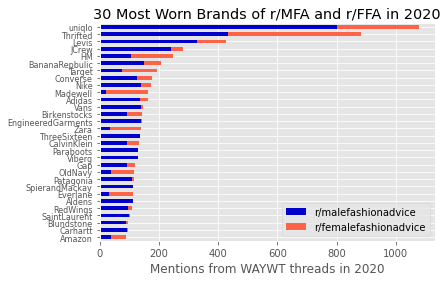

In [37]:
plt.style.use('ggplot')
ax = counts_df.plot.barh(stacked=True,color={r"r/femalefashionadvice":"tomato",r"r/malefashionadvice":"mediumblue"},title='30 Most Worn Brands of r/MFA and r/FFA in 2020')
plt.xlabel('Mentions from WAYWT threads in 2020')
plt.yticks(fontsize=8)
plt.savefig('waywt.png',dpi=300,bbox_inches="tight")